### Numerical Integration

**ScPo Computational Economics 2021**

## Numerical Approximation of Integrals

* We will focus on methods that represent integrals as weighted sums.
* The typical representation will look like:
	$$ E[G(\epsilon)] = \int_{\mathbb{R}^N} G(\epsilon) w(\epsilon) d\epsilon \approx \sum_{j=1}^J \omega_j G(\epsilon_j) $$

$$ E[G(\epsilon)] = \int_{\mathbb{R}^N} G(\epsilon) w(\epsilon) d\epsilon \approx \sum_{j=1}^J \omega_j G(\epsilon_j) $$

* $N$ is the dimensionality of the integration problem.
* $G:\mathbb{R}^N \mapsto \mathbb{R}$ is the function we want to integrate wrt $\epsilon \in \mathbb{R}^N$.
* $w$ is a density function s.t. $\int_{\mathbb{R}^n} w(\epsilon) d\epsilon = 1$.
* $\omega$ are weights such that (most of the time) $\sum_{j=1}^J \omega_j = 1$.
* We will look at normal shocks $\epsilon \sim N(0_N,I_N)$
* in that case, $w(\epsilon) = (2\pi)^{-N/2} \exp \left(-\frac{1}{2}\epsilon^T \epsilon \right)$
* $I_N$ is the n by n identity matrix, i.e. there is no correlation among the shocks for now.
* Other random processes will require different weighting functions, but the principle is identical.
* For now, let's say that $N=1$



## Quadrature Rules

* We focus exclusively on those and leave Simpson and Newton Cowtes formulas out.
	* This is because Quadrature is the method that in many situations gives highes accuracy with lowest computational cost.
* Quadrature provides a rule to compute weights $w_j$ and nodes $\epsilon_j$.
* There are many different quadrature rules.
* They differ in their domain and weighting function.
* [https://en.wikipedia.org/wiki/Gaussian_quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature)
* In general, we can convert our function domain to a rule-specific domain with change of variables.



## Gauss-Hermite: Expectation of a Normally Distributed Variable

* There are many different rules, all specific to a certain random process.
* Gauss-Hermite is designed for an integral of the form
	$$ \int_{-\infty}^{+\infty} e^{-x^2} G(x) dx $$
	and where we would approximate 
	$$ \int_{-\infty}^{+\infty} e^{-x^2} f(x) dx \approx \sum_{i=1}^n \omega_i G(x_i) $$
* Now, let's say we want to approximate the expected value of function $f$ when it's argument $z\sim N(\mu,\sigma^2)$:
	$$ E[f(z)] = \int_{-\infty}^{+\infty} \frac{1}{\sigma \sqrt{2\pi}} \exp \left( -\frac{(z-\mu)^2}{2\sigma^2} \right) f(z) dz $$




## Gauss-Hermite: Expectation of a Normally Distributed Variable

* The rule is defined for $x$ however. We need to transform $z$:
	$$ x = \frac{(z-\mu)^2}{2\sigma^2} \Rightarrow z = \sqrt{2} \sigma x + \mu $$
* This gives us now (just plug in for $z$)
	$$ E[f(z)] = \int_{-\infty}^{+\infty} \frac{1}{ \sqrt{\pi}} \exp \left( -x^2 \right) f(\sqrt{2} \sigma x + \mu) dx $$
* And thus, our approximation to this, using weights $\omega_i$ and nodes $x_i$ is
	$$ E[f(z)] \approx \sum_{j=1}^J \frac{1}{\sqrt{\pi}} \omega_j f(\sqrt{2} \sigma x_j + \mu)$$



## Using Quadrature in Julia

* [https://github.com/ajt60gaibb/FastGaussQuadrature.jl](https://github.com/ajt60gaibb/FastGaussQuadrature.jl)

In [1]:
#Pkg.add("FastGaussQuadrature")

using FastGaussQuadrature

np = 3

rules = Dict("hermite" => gausshermite(np),
             "chebyshev" => gausschebyshev(np),
             "legendre" => gausslegendre(np),
             "lobatto" => gausslobatto(np))

using DataFrames

integ = DataFrame(Rule=Symbol[Symbol(x) for x in keys(rules)],nodes=[x[1] for x in values(rules)],weights=[x[2] for x in values(rules)])

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1278


,Rule,nodes,weights
,Symbol,Array…,Array…
1,lobatto,"[-1.0, 0.0, 1.0]","[0.333333, 1.33333, 0.333333]"
2,hermite,"[-1.22474, -8.88178e-16, 1.22474]","[0.295409, 1.18164, 0.295409]"
3,legendre,"[-0.774597, 0.0, 0.774597]","[0.555556, 0.888889, 0.555556]"
4,chebyshev,"[-0.866025, 6.12323e-17, 0.866025]","[1.0472, 1.0472, 1.0472]"


## Quadrature in more dimensions: Product Rule

* If we have $N>1$, we can use the product rule: this just takes the *kronecker product* of all univariate rules.
* The what?


In [2]:
A = [1 2;3 4]
B = [1;10]
kron(A,B)
kron(B,A)

4×2 Array{Int64,2}:
  1   2
  3   4
 10  20
 30  40

* This works well as long as $N$ is not too large. The number of required function evaluations grows exponentially.
	$$ E[G(\epsilon)] = \int_{\mathbb{R}^N} G(\epsilon) w(\epsilon) d\epsilon \approx \sum_{j_1=1}^{J_1} \cdots \sum_{j_N=1}^{J_N} \omega_{j_1}^1 \cdots \omega_{j_N}^N G(\epsilon_{j_1}^1,\dots,\epsilon_{j_N}^N) $$
	where $\omega_{j_1}^1$ stands for weight index $j_1$ in dimension 1, same for $\epsilon$.
* Total number of nodes: $J=J_1 J_2 \cdots J_N$, and $J_i$ can differ from $J_k$.



### Example for $N=3$

* Suppose we have $\epsilon^i \sim N(0,1),i=1,2,3$ as three uncorrelated random variables.
* Let's take $J=3$ points in all dimensions, so that in total we have $J^N=27$ points.
* We have the nodes and weights from before in `rules["hermite"]`.

In [3]:
rules["hermite"][1]
repeat(rules["hermite"][1],inner=[1],outer=[9])

27-element Array{Float64,1}:
 -1.2247448713915892
 -8.881784197001252e-16
  1.2247448713915892
 -1.2247448713915892
 -8.881784197001252e-16
  1.2247448713915892
 -1.2247448713915892
 -8.881784197001252e-16
  1.2247448713915892
 -1.2247448713915892
 -8.881784197001252e-16
  1.2247448713915892
 -1.2247448713915892
  ⋮
 -1.2247448713915892
 -8.881784197001252e-16
  1.2247448713915892
 -1.2247448713915892
 -8.881784197001252e-16
  1.2247448713915892
 -1.2247448713915892
 -8.881784197001252e-16
  1.2247448713915892
 -1.2247448713915892
 -8.881784197001252e-16
  1.2247448713915892

In [4]:
nodes = Any[]
push!(nodes,repeat(rules["hermite"][1],inner=[1],outer=[9]))  # dim1
push!(nodes,repeat(rules["hermite"][1],inner=[3],outer=[3]))  # dim2
push!(nodes,repeat(rules["hermite"][1],inner=[9],outer=[1]))  # dim3
weights = kron(rules["hermite"][2],kron(rules["hermite"][2],rules["hermite"][2]))
df = hcat(DataFrame(weights=weights),DataFrame(nodes,[:dim1,:dim2,:dim3]))

,weights,dim1,dim2,dim3
,Float64,Float64,Float64,Float64
1,0.0257793,-1.22474,-1.22474,-1.22474
2,0.103117,-8.88178e-16,-1.22474,-1.22474
3,0.0257793,1.22474,-1.22474,-1.22474
4,0.103117,-1.22474,-8.88178e-16,-1.22474
5,0.412469,-8.88178e-16,-8.88178e-16,-1.22474
6,0.103117,1.22474,-8.88178e-16,-1.22474
7,0.0257793,-1.22474,1.22474,-1.22474
8,0.103117,-8.88178e-16,1.22474,-1.22474
9,0.0257793,1.22474,1.22474,-1.22474


* Imagine you had a function $g$ defined on those 3 dims: in order to approximate the integral, you would have to evaluate $g$ at all combinations of `dimx`, multiply with the corresponding weight, and sum.


### Alternatives to the Product Rule

* Monomial Rules: They grow only linearly.
* Please refer to [juddbook] <cite data-cite=juddbook></cite> for more details.




## Monte Carlo Integration

* A widely used method is to just draw $N$ points randomly from the space of the shock $\epsilon$, and to assign equal weights $\omega_j=\frac{1}{N}$ to all of them.
* The expectation is then
	$$ E[G(\epsilon)] \approx \frac{1}{N} \sum_{j=1}^N  G(\epsilon_j) $$
* This in general a very inefficient method.
* Particularly in more than 1 dimensions, the number of points needed for good accuracy is very large.
* Monte Carlo has a rate of convergence of $\mathcal{O}(n^{-0.5})$

## Quasi Monte Carlo Integration

* The researcher controlls the number of points. 
* We need to construct equidistributed points.
* Typically one uses a low-discrepancy sequence of points, e.g. the Weyl sequence:
* $x_n = {n v}$ where $v$ is an irrational number and `{}` stands for the fractional part of a number. for $v=\sqrt{2}$,
	$$ x_1 = \{1 \sqrt{2}\} = \{1.4142\} = 0.4142, x_2 = \{2 \sqrt{2}\} = \{2.8242\} = 0.8242,... $$
* Other low-discrepancy sequences are Niederreiter, Haber, Baker or Sobol.
* Quasi Monte Carlo has a rate of convergence of close to $\mathcal{O}(n^{-1})$
* [The wikipedia entry is good](https://en.wikipedia.org/wiki/Quasi-Monte_Carlo_method).

![](sobol.png)

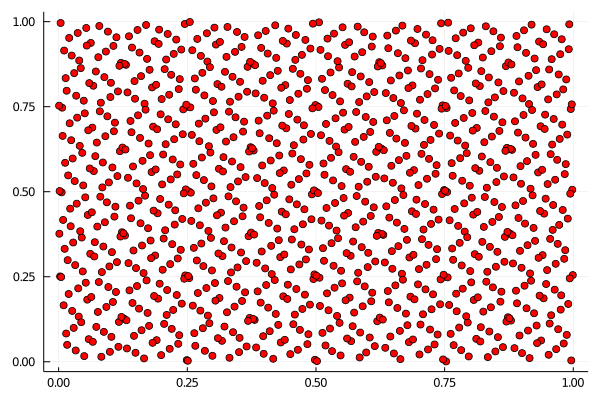

In [5]:
# Pkg.add("Sobol")
using Sobol
using Plots
s = SobolSeq(2)
p = hcat([next!(s) for i = 1:1024]...)'
scatter(p[:,1], p[:,2], m=(:red,:dot,1.0),legend=false)

 ## Correlated Shocks

* We often face situations where the shocks are in fact correlated.
	* One very typical case is an AR1 process:
	$$ z_{t+1} = \rho z_t + \varepsilon_t, \varepsilon \sim N(0,\sigma^2) $$
* The general case is again:
	$$ E[G(\epsilon)] = \int_{\mathbb{R}^N} G(\epsilon) w(\epsilon) d\epsilon \approx \sum_{j_1=1}^{J_1} \cdots \sum_{j_N=1}^{J_N} \omega_{j_1}^1 \cdots \omega_{j_N}^N G(\epsilon_{j_1}^1,\dots,\epsilon_{j_N}^N) $$

* Now $\epsilon \sim N(\mu,\Sigma)$ where $\Sigma$ is an N by N variance-covariance matrix.
* The multivariate density is
	$$w(\epsilon) = (2\pi)^{-N/2} det(\Sigma)^{-1/2} \exp \left(-\frac{1}{2}(\epsilon - \mu)^T (\epsilon - \mu) \right)$$
* We need to perform a change of variables before we can integrate this.
* Given $\Sigma$ is symmetric and positive semi-definite, it has a Cholesky decomposition, 
	$$ \Sigma = \Omega \Omega^T $$
	where $\Omega$ is a lower-triangular with strictly positive entries.
* The linear change of variables is then
	$$ v = \Omega^{-1} (\epsilon - \mu)  $$



* Plugging this in gives
	$$ \sum_{j=1}^J \omega_j  G(\Omega v_j + \mu) \equiv \sum_{j=1}^J \omega_j  G(\epsilon_j) $$
	where $v\sim N(0,I_N)$.
* So, we can follow the exact same steps as with the uncorrelated shocks, but need to adapt the nodes.








## References

* The Integration part of these slides are based on [@maliar-maliar] <cite data-cite=maliarmaliar></cite> chapter 5